In [3]:
mypath = './data'

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D
from tensorflow.keras import models, layers

from tqdm import tqdm
import seaborn as sns
import pickle
from os import path
import matplotlib.pyplot as plt

In [5]:
data = pd.read_csv('winemag-data-130k-v2.csv')
data = data.drop(data.columns[0], axis= 1)
data = data.drop(['designation', 'points','region_1', 'region_2',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle','winery'],axis=1)
data = data[['country', 'description', 'price', 'province', 'title', 'variety']].dropna()
## 총 500개가 안되는 나라 삭제
threshold = 500 
value_counts = data['country'].value_counts()
to_remove = value_counts[value_counts <= threshold].index
data.replace(to_remove, np.nan, inplace= True)
data = data[pd.notnull(data['country'])]

In [6]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [7]:
#country labeling
encoder = preprocessing.LabelEncoder()
encoder.fit(data.country)
encoder.classes_
encoded_country = encoder.transform(data.country)

In [8]:
#variety labling _never used
encoder2 = preprocessing.LabelEncoder()
encoder2.fit(data.variety)
encoder2.classes_
encoded_variety = encoder2.transform(data.variety)

In [9]:
description = data['description']
description

1         This is ripe and fruity, a wine that is smooth...
2         Tart and snappy, the flavors of lime flesh and...
3         Pineapple rind, lemon pith and orange blossom ...
4         Much like the regular bottling from 2012, this...
5         Blackberry and raspberry aromas show a typical...
                                ...                        
129966    Notes of honeysuckle and cantaloupe sweeten th...
129967    Citation is given as much as a decade of bottl...
129968    Well-drained gravel soil gives this wine its c...
129969    A dry style of Pinot Gris, this is crisp with ...
129970    Big, rich and off-dry, this is powered by inte...
Name: description, Length: 118458, dtype: object

In [10]:
#one-hot encode the description
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
t = Tokenizer()
t.fit_on_texts(description)
vocab_size = len(t.word_index)+1
description_encoded = t.texts_to_sequences(description)
max_len=max(len(l) for l in description_encoded)
description = pad_sequences(description_encoded, maxlen=max_len, padding='post')

In [11]:
description

array([[    6,     7,    27, ...,     0,     0,     0],
       [  109,     1,   891, ...,     0,     0,     0],
       [  203,   622,    76, ...,     0,     0,     0],
       ...,
       [   51, 16200,  1538, ...,     0,     0,     0],
       [    3,    39,   106, ...,     0,     0,     0],
       [  184,    41,     1, ...,     0,     0,     0]], dtype=int32)

In [12]:
 #making embedding layer
 import gensim
 word2vec = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary = True)
 print(word2vec.vectors.shape)
 embedding_matrix = np.zeros((vocab_size,300))
 def get_vector(word) :
     if word in word2vec :
         return word2vec[word]
     else:
         return None
 for word, i in t.word_index.items():
     temp = get_vector(word)
     if temp is not None :b
         embedding_matrix[i] = temp

In [14]:
with open(path.join(mypath,'embedding_matrix'),'rb') as f:
    embedding_matrix = pickle.load(f)

In [15]:
#test train split
X_train, X_test, y_train, y_test = train_test_split(description, encoded_country, test_size=0.2, stratify=encoded_country) 

In [16]:
'''
with open(path.join(mypath,'X_train'),'wb') as f:
     pickle.dump(X_train, f)
with open(path.join(mypath,'X_test'),'wb') as f:
     pickle.dump(X_test, f)
with open(path.join(mypath,'y_train'),'wb') as f:
     pickle.dump(y_train, f)
with open(path.join(mypath,'y_test'),'wb') as f:
     pickle.dump(y_test, f)
    

with open(path.join(mypath,'X_train'),'rb') as f:
    X_train = pickle.load(f)
with open(path.join(mypath,'X_test'),'rb') as f:
    X_test = pickle.load(f)
with open(path.join(mypath,'y_train'),'rb') as f:
    y_train = pickle.load(f)
with open(path.join(mypath,'y_test'),'rb') as f:
    y_test = pickle.load(f)
'''   

In [16]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

In [18]:
#test validation split
X_train, X_val, y_train, y_val =  train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [19]:
print(X_train.shape)
print(X_val.shape)

(75812, 136)
(18954, 136)


In [20]:
tensor = X_test[:1]

In [21]:
class MyModel(models.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
        self.conv = layers.Conv1D(filters=250,kernel_size=1,strides=1,padding='valid',activation='relu')
        self.gap = layers.GlobalAveragePooling1D()
        self.dense = layers.Dense(12)
        self.softmax = layers.Activation('softmax')
        
    def call(self, inputs):
        e = self.e(inputs)
        conv = self.conv(e)
        gap = self.gap(conv)
        dense = self.dense(gap)
        outputs = self.softmax(dense)
        return outputs, dense, conv

clf = MyModel()
clf.build(input_shape=(None, max_len))
print(clf.summary())

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  10722300  
_________________________________________________________________
conv1d (Conv1D)              multiple                  75250     
_________________________________________________________________
global_average_pooling1d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3012      
_________________________________________________________________
activation (Activation)      multiple                  0         
Total params: 10,800,562
Trainable params: 78,262
Non-trainable params: 10,722,300
_________________________________________________________________
None


In [22]:
BATCH_SIZE = 2**10
ETA = 1e-3
EPOCH = 100
cce = tf.keras.losses.SparseCategoricalCrossentropy()
opt = tf.keras.optimizers.Adam(learning_rate=ETA)
train_loss_results = []
train_accuracy_results = []

for e in range(EPOCH):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    loss_sum = .0
    
    for step in tqdm(range(0, len(X_train), BATCH_SIZE)):
        start = step
        end = min(step + BATCH_SIZE, len(X_train))
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        with tf.GradientTape() as tape:
            y_pred, _, _ = clf(X_batch)
            loss = cce(y_batch, y_pred)

        grads = tape.gradient(loss, clf.trainable_variables)
        opt.apply_gradients(zip(grads, clf.trainable_variables))
        loss_sum += loss
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())
    
#   if (e+1)%1 == 0:
    print(f'{e+1}/{EPOCH}, loss = {loss_sum:.4f}')

  0%|          | 0/75 [00:00<?, ?it/s]

1/100, loss = 144.8715


  0%|          | 0/75 [00:00<?, ?it/s]

2/100, loss = 126.5621


  0%|          | 0/75 [00:00<?, ?it/s]

3/100, loss = 113.9960


  0%|          | 0/75 [00:00<?, ?it/s]

4/100, loss = 102.1394


  0%|          | 0/75 [00:00<?, ?it/s]

5/100, loss = 92.2304


  0%|          | 0/75 [00:00<?, ?it/s]

6/100, loss = 84.5336


  0%|          | 0/75 [00:00<?, ?it/s]

7/100, loss = 78.9026


  0%|          | 0/75 [00:00<?, ?it/s]

8/100, loss = 74.6960


  0%|          | 0/75 [00:00<?, ?it/s]

9/100, loss = 71.3904


  0%|          | 0/75 [00:00<?, ?it/s]

10/100, loss = 68.7005


  0%|          | 0/75 [00:00<?, ?it/s]

11/100, loss = 66.4615


  0%|          | 0/75 [00:00<?, ?it/s]

12/100, loss = 64.5639


  0%|          | 0/75 [00:00<?, ?it/s]

13/100, loss = 62.9281


  0%|          | 0/75 [00:00<?, ?it/s]

14/100, loss = 61.4970


  0%|          | 0/75 [00:00<?, ?it/s]

15/100, loss = 60.2278


  0%|          | 0/75 [00:00<?, ?it/s]

16/100, loss = 59.0907


  0%|          | 0/75 [00:00<?, ?it/s]

17/100, loss = 58.0601


  0%|          | 0/75 [00:00<?, ?it/s]

18/100, loss = 57.1190


  0%|          | 0/75 [00:00<?, ?it/s]

19/100, loss = 56.2534


  0%|          | 0/75 [00:00<?, ?it/s]

20/100, loss = 55.4527


  0%|          | 0/75 [00:00<?, ?it/s]

21/100, loss = 54.7084


  0%|          | 0/75 [00:00<?, ?it/s]

22/100, loss = 54.0127


  0%|          | 0/75 [00:00<?, ?it/s]

23/100, loss = 53.3595


  0%|          | 0/75 [00:00<?, ?it/s]

24/100, loss = 52.7436


  0%|          | 0/75 [00:00<?, ?it/s]

25/100, loss = 52.1611


  0%|          | 0/75 [00:00<?, ?it/s]

26/100, loss = 51.6100


  0%|          | 0/75 [00:00<?, ?it/s]

27/100, loss = 51.0859


  0%|          | 0/75 [00:00<?, ?it/s]

28/100, loss = 50.5874


  0%|          | 0/75 [00:00<?, ?it/s]

29/100, loss = 50.1121


  0%|          | 0/75 [00:00<?, ?it/s]

30/100, loss = 49.6579


  0%|          | 0/75 [00:00<?, ?it/s]

31/100, loss = 49.2235


  0%|          | 0/75 [00:00<?, ?it/s]

32/100, loss = 48.8075


  0%|          | 0/75 [00:00<?, ?it/s]

33/100, loss = 48.4088


  0%|          | 0/75 [00:00<?, ?it/s]

34/100, loss = 48.0264


  0%|          | 0/75 [00:00<?, ?it/s]

35/100, loss = 47.6588


  0%|          | 0/75 [00:00<?, ?it/s]

36/100, loss = 47.3051


  0%|          | 0/75 [00:00<?, ?it/s]

37/100, loss = 46.9642


  0%|          | 0/75 [00:00<?, ?it/s]

38/100, loss = 46.6346


  0%|          | 0/75 [00:00<?, ?it/s]

39/100, loss = 46.3169


  0%|          | 0/75 [00:00<?, ?it/s]

40/100, loss = 46.0098


  0%|          | 0/75 [00:00<?, ?it/s]

41/100, loss = 45.7121


  0%|          | 0/75 [00:00<?, ?it/s]

42/100, loss = 45.4237


  0%|          | 0/75 [00:00<?, ?it/s]

43/100, loss = 45.1443


  0%|          | 0/75 [00:00<?, ?it/s]

44/100, loss = 44.8732


  0%|          | 0/75 [00:00<?, ?it/s]

45/100, loss = 44.6102


  0%|          | 0/75 [00:00<?, ?it/s]

46/100, loss = 44.3545


  0%|          | 0/75 [00:00<?, ?it/s]

47/100, loss = 44.1060


  0%|          | 0/75 [00:00<?, ?it/s]

48/100, loss = 43.8640


  0%|          | 0/75 [00:00<?, ?it/s]

49/100, loss = 43.6292


  0%|          | 0/75 [00:00<?, ?it/s]

50/100, loss = 43.4003


  0%|          | 0/75 [00:00<?, ?it/s]

51/100, loss = 43.1772


  0%|          | 0/75 [00:00<?, ?it/s]

52/100, loss = 42.9600


  0%|          | 0/75 [00:00<?, ?it/s]

53/100, loss = 42.7480


  0%|          | 0/75 [00:00<?, ?it/s]

54/100, loss = 42.5413


  0%|          | 0/75 [00:00<?, ?it/s]

55/100, loss = 42.3404


  0%|          | 0/75 [00:00<?, ?it/s]

56/100, loss = 42.1437


  0%|          | 0/75 [00:00<?, ?it/s]

57/100, loss = 41.9516


  0%|          | 0/75 [00:00<?, ?it/s]

58/100, loss = 41.7641


  0%|          | 0/75 [00:00<?, ?it/s]

59/100, loss = 41.5807


  0%|          | 0/75 [00:00<?, ?it/s]

60/100, loss = 41.4014


  0%|          | 0/75 [00:00<?, ?it/s]

61/100, loss = 41.2262


  0%|          | 0/75 [00:00<?, ?it/s]

62/100, loss = 41.0544


  0%|          | 0/75 [00:00<?, ?it/s]

63/100, loss = 40.8864


  0%|          | 0/75 [00:00<?, ?it/s]

64/100, loss = 40.7213


  0%|          | 0/75 [00:00<?, ?it/s]

65/100, loss = 40.5596


  0%|          | 0/75 [00:00<?, ?it/s]

66/100, loss = 40.4010


  0%|          | 0/75 [00:00<?, ?it/s]

67/100, loss = 40.2456


  0%|          | 0/75 [00:00<?, ?it/s]

68/100, loss = 40.0931


  0%|          | 0/75 [00:00<?, ?it/s]

69/100, loss = 39.9434


  0%|          | 0/75 [00:00<?, ?it/s]

70/100, loss = 39.7966


  0%|          | 0/75 [00:00<?, ?it/s]

71/100, loss = 39.6527


  0%|          | 0/75 [00:00<?, ?it/s]

72/100, loss = 39.5113


  0%|          | 0/75 [00:00<?, ?it/s]

73/100, loss = 39.3724


  0%|          | 0/75 [00:00<?, ?it/s]

74/100, loss = 39.2357


  0%|          | 0/75 [00:00<?, ?it/s]

75/100, loss = 39.1011


  0%|          | 0/75 [00:00<?, ?it/s]

76/100, loss = 38.9694


  0%|          | 0/75 [00:00<?, ?it/s]

77/100, loss = 38.8395


  0%|          | 0/75 [00:00<?, ?it/s]

78/100, loss = 38.7122


  0%|          | 0/75 [00:00<?, ?it/s]

79/100, loss = 38.5865


  0%|          | 0/75 [00:00<?, ?it/s]

80/100, loss = 38.4631


  0%|          | 0/75 [00:00<?, ?it/s]

81/100, loss = 38.3418


  0%|          | 0/75 [00:00<?, ?it/s]

82/100, loss = 38.2224


  0%|          | 0/75 [00:00<?, ?it/s]

83/100, loss = 38.1047


  0%|          | 0/75 [00:00<?, ?it/s]

84/100, loss = 37.9885


  0%|          | 0/75 [00:00<?, ?it/s]

85/100, loss = 37.8743


  0%|          | 0/75 [00:00<?, ?it/s]

86/100, loss = 37.7618


  0%|          | 0/75 [00:00<?, ?it/s]

87/100, loss = 37.6511


  0%|          | 0/75 [00:00<?, ?it/s]

88/100, loss = 37.5418


  0%|          | 0/75 [00:00<?, ?it/s]

89/100, loss = 37.4340


  0%|          | 0/75 [00:00<?, ?it/s]

90/100, loss = 37.3276


  0%|          | 0/75 [00:00<?, ?it/s]

91/100, loss = 37.2226


  0%|          | 0/75 [00:00<?, ?it/s]

92/100, loss = 37.1191


  0%|          | 0/75 [00:00<?, ?it/s]

93/100, loss = 37.0173


  0%|          | 0/75 [00:00<?, ?it/s]

94/100, loss = 36.9168


  0%|          | 0/75 [00:00<?, ?it/s]

95/100, loss = 36.8175


  0%|          | 0/75 [00:00<?, ?it/s]

96/100, loss = 36.7197


  0%|          | 0/75 [00:00<?, ?it/s]

97/100, loss = 36.6232


  0%|          | 0/75 [00:00<?, ?it/s]

98/100, loss = 36.5280


  0%|          | 0/75 [00:00<?, ?it/s]

99/100, loss = 36.4340


100%|██████████| 75/75 [00:15<00:00,  4.69it/s]

100/100, loss = 36.3408


In [37]:
y_test.shape

(23692,)

In [23]:
def get_relu(m):
    assert len(m.shape) == 2
    
    _m = np.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            _m[i][j] = max(0,m[i][j])
            
    return _m

In [24]:
with tf.GradientTape() as tape:
    X = tensor
    _, output, last_conv_layer = clf(X)
    output = output[:,cls]

print('last_conv_layer',last_conv_layer.shape)
grads = tape.gradient(output, last_conv_layer)
pooled_grads = tf.reduce_mean(grads,axis=(0,1))
print('pooled_grads',pooled_grads.shape)

temp = last_conv_layer * pooled_grads
heatmap = np.mean(temp, axis=-1)
heatmap = get_relu(heatmap)
print('heatmap',heatmap.shape)

last_conv_layer (1, 136, 250)
pooled_grads (250,)
heatmap (1, 136)


In [27]:
def num_to_text(seq):
    sentence = []
    for i in range(len(seq)):
        if seq[i] == 0:
            break
        sentence.append(t.index_word.get(seq[i]))
    return sentence
sentence = num_to_text(X[0])

In [28]:
print(list(zip(np.arange(len(sentence)),sentence)))

[(0, 'the'), (1, 'new'), (2, 'mercer'), (3, 'canyons'), (4, 'label'), (5, 'gets'), (6, 'off'), (7, 'to'), (8, 'a'), (9, 'good'), (10, 'start'), (11, 'with'), (12, 'this'), (13, 'chardonnay'), (14, "that's"), (15, 'low'), (16, 'in'), (17, 'alcohol'), (18, 'and'), (19, 'clean'), (20, 'bracing'), (21, 'and'), (22, 'leesy'), (23, 'this'), (24, 'is'), (25, 'definitely'), (26, 'european'), (27, 'in'), (28, 'style'), (29, 'and'), (30, 'it'), (31, 'offers'), (32, 'celery'), (33, 'and'), (34, 'melon'), (35, 'flavors'), (36, 'along'), (37, 'with'), (38, 'palate'), (39, 'refreshing'), (40, 'minerality')]


In [29]:
' '.join(sentence)

"the new mercer canyons label gets off to a good start with this chardonnay that's low in alcohol and clean bracing and leesy this is definitely european in style and it offers celery and melon flavors along with palate refreshing minerality"

In [30]:
predicted = clf.predict(X_test)[0]

In [31]:
predicted.shape

(23692, 12)

In [32]:
x = X_test[:1]
x_pred, output, last_conv_layer = clf(x)
cls = np.argmax(x_pred, axis =1)[0]
cls

11

In [48]:
heatmap_list = []
for x in tqdm(X_test) :
    x = x.reshape(1,-1)
    with tf.GradientTape() as tape:
        x_pred, output, last_conv_layer = clf(x)
        cls = np.argmax(x_pred, axis =1)[0]
        output = output[:,cls]

    #print('last_conv_layer',last_conv_layer.shape)
    grads = tape.gradient(output, last_conv_layer)
    pooled_grads = tf.reduce_mean(grads,axis=(0,1))
    #print('pooled_grads',pooled_grads.shape)

    temp = last_conv_layer * pooled_grads
    heatmap = np.mean(temp, axis=-1)
    heatmap = get_relu(heatmap)
    #print('heatmap',heatmap.shape)
    heatmap_list.append(heatmap)

100%|██████████| 23692/23692 [02:09<00:00, 182.86it/s]


In [58]:
#X_pred = clf(X_test)[0]
X_pred = np.argmax(X_pred, axis=1)

In [59]:
data_list = []
for i in range(len(X_test)) :
    data_list.append([X_pred[i],y_test[i],X_test[i],heatmap_list[i].reshape(-1)])

In [65]:
Argentina =[]
Australia=[]
Austria=[]
Chile=[]
France=[]
Germany=[]
Italy=[]
New_Zealand=[]
Portugal=[]
South_Africa=[]
Spain=[]
US=[]

In [ ]:
nations = [Argentina,Australia,Austria,Chile,France,Germany,Italy,New_Zealand,Portugal,South_Africa,Spain,US]
for data in data_list :
    nations[data[0]].append(data)


In [80]:
activations = []
word_counts = []
for nation in tqdm(nations) :
    activation = np.zeros(len(t.word_index)+1)
    word_count = np.zeros(len(t.word_index)+1)
    for test in nation :
         for dd in range(136) :
            if test[2][dd] == 0 :
                break
            else :
                maximun = test[3].max()
                activation[test[2][dd]] += (test[3][dd])
                word_count[test[2][dd]] += 1
    activations.append(activation)
    word_counts.append(word_count)

100%|██████████| 12/12 [00:14<00:00,  1.19s/it]


In [73]:
len(activations)

12

In [ ]:
activation = np.zeros(len(t.word_index)+1)
word_count = np.zeros(len(t.word_index)+1)
for test in Argentina :    
    for dd in range(136) :
#        print(test[2][dd])
#        print(test[3][0,dd])
        if test[2][dd] == 0 : 
            break
        else : 
            maximun = test[3].max()
            activation[test[2][dd]] += (test[3][dd])
            word_count[test[2][dd]] += 1

In [82]:
reverse_word_map = dict(map(reversed, t.word_index.items()))

In [ ]:
print(word_count.shape)
print(activation.shape)

In [349]:
import pandas as pd
word_count = word_counts[6]
activation = activations[6]
d = {'word_count': word_count,'activation': activation}
df = pd.DataFrame(d)
df = df.loc[(df['word_count'] > 0) & (df['activation'] > 0 )]
df['word_count'] = df['word_count'].astype('int64')
df['activation'] = df['activation'] / df['word_count']
index = df.index.tolist()
word = [reverse_word_map[x] for x in index]
df['word'] = word
df = df.set_index('word')


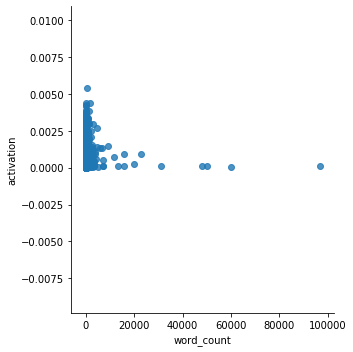

In [84]:

sns.lmplot('word_count', 'activation', data=df, fit_reg=False,)

In [274]:
df = df.sort_values(by='activation', ascending = False)
top100 = df.head(100)
top100 = top100.drop_duplicates('word_count')

In [353]:
df = df.loc[(df['word_count'] < 5000) & df['activation'] > 0.005]

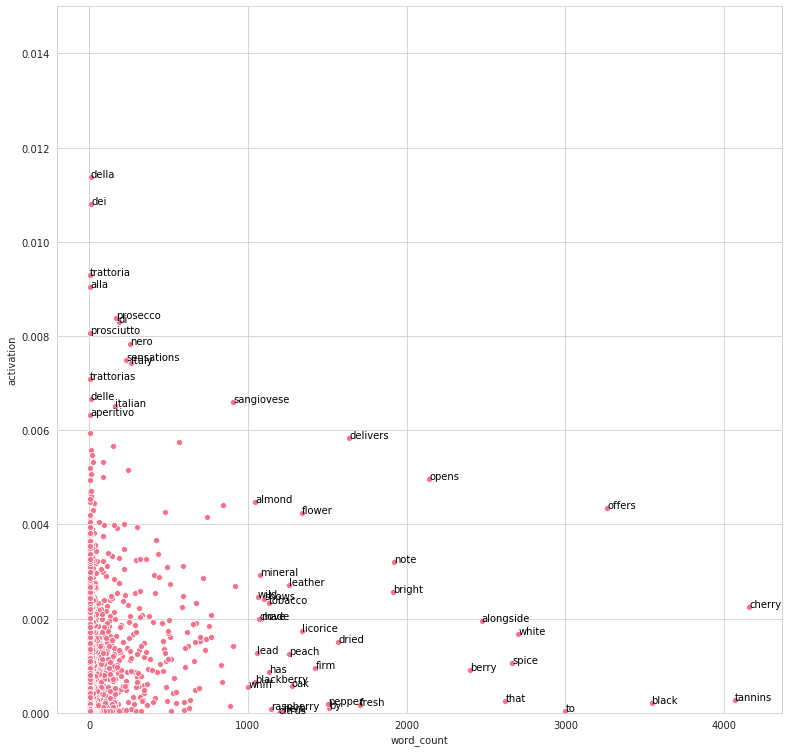

In [357]:
f, ax = plt.subplots(figsize=(13,13))
sns.set_style('whitegrid')
p1= sns.scatterplot(x="word_count", y="activation", data=df)
#p1.set(ylim=(0,0.0055),  yticks=[0.0025,0.00375,0.0055], yticklabels=['low','medium','high'], xlim=(1, 5000))
p1.set(ylim=(0,0.015))
for line in range(0,df.shape[0]):
       if (df.activation[line] > 0.006) or (df.word_count[line] > 1000) :
            p1.text(df.word_count[line]+0.4, df.activation[line], df.index[line], horizontalalignment='left', size='medium', color='black')
plt.show(p1)
#fig = p1.get_figure()
#fig.savefig('output.png') 

In [ ]:
df = df.set_index('word')

In [ ]:
df.loc[(df['word_count'] == 1) & (df['activation'] > 0.002)]

[[<matplotlib.axis.YTick at 0x7fbc885c5e10>,
 [Text(0, 0, 'low'), Text(0, 0, 'medium'), Text(0, 0, 'high')],
 (0, 0.005)]

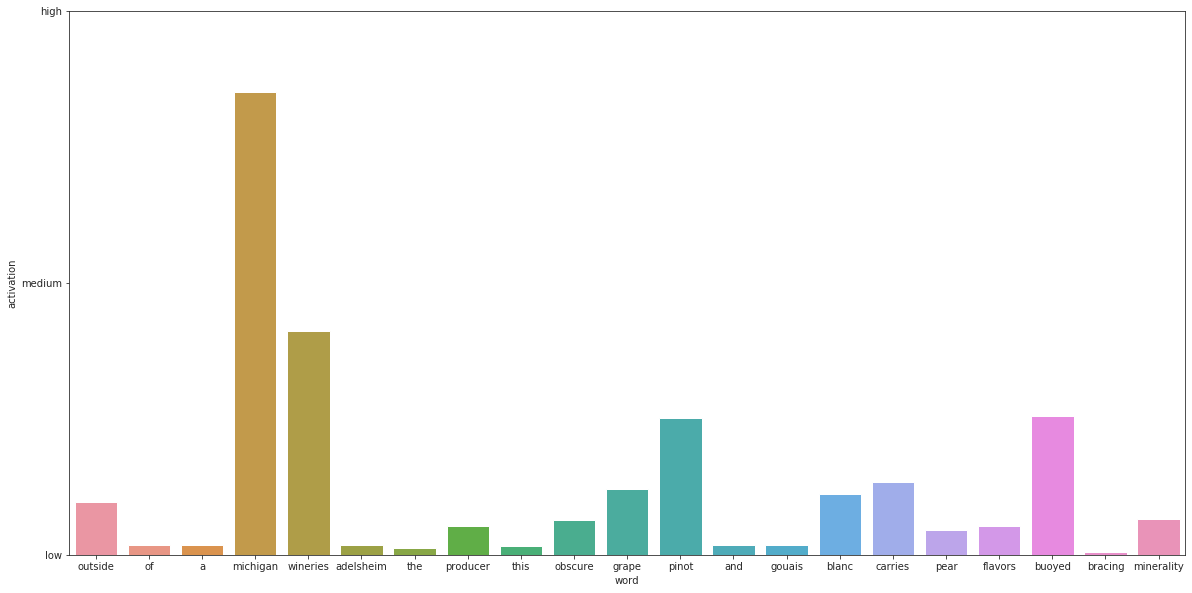

In [195]:
g = sns.barplot(x='word', y='activation', data=only_pd2)
#g.set(yticklabels=['low', ' ',' ',' ',' ',' ',' ',' ', 'high'])
#sns.set_style("ticks",{"xtick.major.size":8,"ytick.major.size":8})
g.set(ylim=(0,0.005),  yticks=[0,0.0025,0.005], yticklabels=['low','medium','high'])
